In [1]:
import numpy as np
import pandas as pd
import glob
import gzip
import tqdm

### Get station metadata

In [4]:
# read station metadata
meta = pd.read_csv('../../data/pems/d07_text_meta_2021_10_20.txt', sep='\t')
meta = meta[['ID', 'Fwy', 'Dir', 'District', 'County', 'City', 'State_PM', 'Abs_PM',
             'Latitude', 'Longitude', 'Length', 'Type', 'Lanes', 'Name']]

meta.head()

,ID,Fwy,Dir,District,County,City,State_PM,Abs_PM,Latitude,Longitude,Length,Type,Lanes,Name
0,715898,5,S,7,37,40032.0,.71,117.280,33.880183,-118.021787,0.43,ML,3,PHOEBE
1,715900,5,S,7,37,40032.0,1.06,117.630,33.882892,-118.026822,NaN,OR,1,VALLEY VIEW
2,715901,5,N,7,37,40032.0,1.11,117.743,33.883400,-118.027451,NaN,OR,1,VALLEY VIEW
3,715903,5,N,7,37,69154.0,1.56,118.193,33.886992,-118.034125,NaN,OR,1,ALONDRA
4,715904,5,S,7,37,69154.0,2.27,118.840,33.892489,-118.044573,NaN,OR,1,CARMENITA


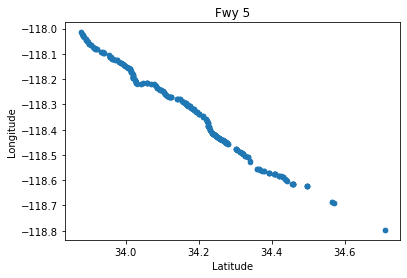

In [13]:
# select Fwy 5
df = meta[meta['Fwy'] == 5]
p = df.plot.scatter('Latitude','Longitude', title='Fwy 5')

In [14]:
# get station IDs for mainlines
ml = df[df['Type'] == 'ML']
ml = ml.sort_values('Abs_PM')
northbound_stations = list(ml[ml['Dir'] == 'N']['ID'])
southbound_stations = list(ml[ml['Dir'] == 'S']['ID'])

### Analyze route (single day)

See the speed along a route (Fwy 5 northbound) to identify bottlenecks

In [16]:
# read speed data
# using Tue June 1 as an example date
data_dict = pd.read_csv('../../data/pems/station_dict.csv', names=['Feature', 'Description', 'Unit']).iloc[1:].reset_index(drop=True)
colnames = data_dict['Feature'].values.tolist()
colnames_subset = ['Timestamp', 'Station', 'Station Length', 'Samples', 'Total Flow', 'Avg Occupancy', 'Avg Speed', 
                   'Lane N Samples', 'Lane N Flow', 'Lane N Avg Occ', 'Lane N Avg Speed', 'Lane N Observed']

files = glob.glob('../../data/pems/*.gz')
with gzip.open(files[151]) as f:
    df = pd.read_csv(f, index_col=False, names=colnames)[colnames_subset]

df['Timestamp'] = pd.to_datetime(df['Timestamp'])

In [17]:
# northbound route analysis

# filter and get postmile
sub = df[[x in northbound_stations for x in df['Station']]]
sub = pd.DataFrame(sub.reset_index(drop=True))
sub['Postmile'] = [station_to_abs_pm[x] for x in sub['Station']]
route = pd.DataFrame(sub)
route.head()

,Timestamp,Station,Station Length,Samples,Total Flow,Avg Occupancy,Avg Speed,Lane N Samples,Lane N Flow,Lane N Avg Occ,Lane N Avg Speed,Lane N Observed,Postmile
0,2021-02-22,715918,0.885,0,159.0,0.0296,69.4,0.0,42.0,0.0210,73.2,0,122.833
1,2021-02-22,715930,0.505,40,112.0,0.0233,69.8,10.0,37.0,0.0289,74.8,1,126.133
2,2021-02-22,715933,0.425,40,110.0,0.0200,69.8,10.0,25.0,0.0154,74.8,1,126.963
3,2021-02-22,715938,0.545,40,137.0,0.0258,70.2,10.0,48.0,0.0422,74.8,1,128.813
4,2021-02-22,715944,0.323,40,228.0,0.0696,64.5,10.0,49.0,0.0573,69.7,0,129.983


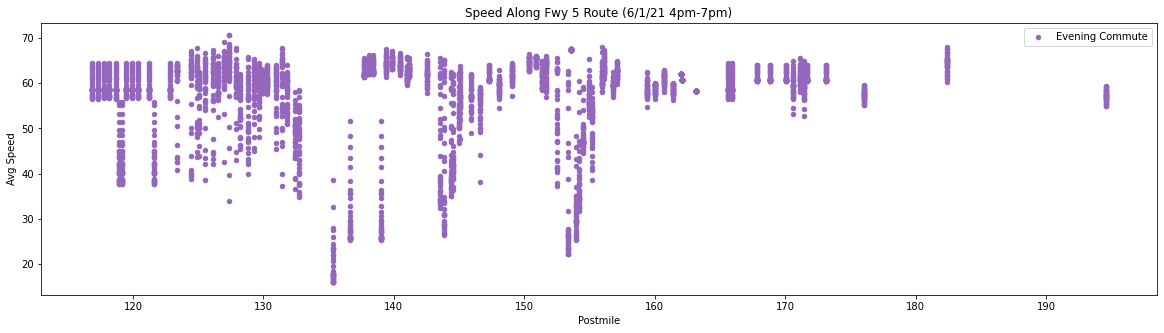

In [18]:
route['Time Group'] = ['Morning Commute' if x.hour >= 7 and x.hour <= 9 \
                 else 'Evening Commute' if x.hour >= 16 and x.hour <= 18 else None \
                 for x in route['Timestamp']]

p = route[route['Time Group'] == 'Evening Commute'].plot.scatter(
    'Postmile', 'Avg Speed', color='tab:purple', label='Evening Commute', 
    figsize=(20,5), title='Speed Along Fwy 5 Route (6/1/21 4pm-7pm)'
)

### Analyze route

Average speeds during the month of June along Fwy 5 Northbound route

In [9]:
# load data for entire month of June
data_list = []
for i in tqdm.tqdm( range(151, 181) ):
    with gzip.open(files[i]) as f:
        df = pd.read_csv(f, index_col=False, names=colnames)[colnames_subset]
        df['Timestamp'] = pd.to_datetime(df['Timestamp'])

        sub = df[[x in northbound_stations for x in df['Station']]]
        sub = pd.DataFrame(sub.reset_index(drop=True))
        sub['Postmile'] = [station_to_abs_pm[x] for x in sub['Station']]
        data_list.append(sub)   

df = pd.concat(data_list)

100%|██████████| 30/30 [03:19<00:00,  6.66s/it]


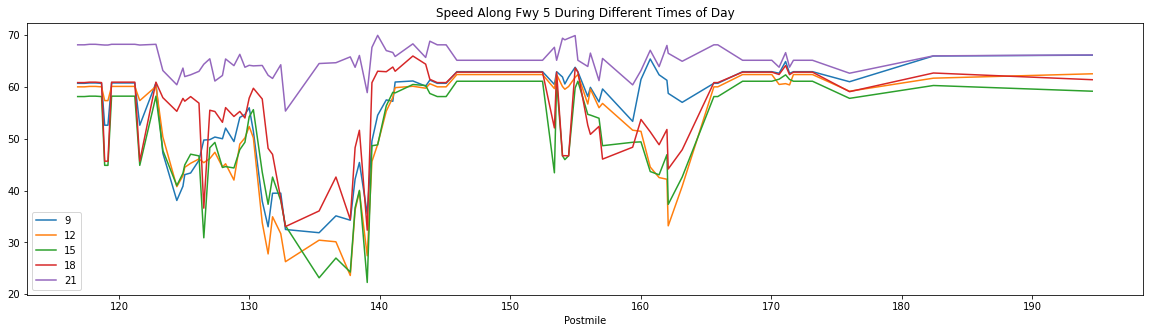

In [10]:
# compute average speed for different hours of the day along the route
d = {}
for h in [9, 12, 15, 18, 21]:
    d[h] = df[[x.hour == h for x in df['Timestamp']]].groupby('Postmile').mean()['Avg Speed']

p = pd.DataFrame(d).plot(figsize=(20,5), title='Speed Along Fwy 5 During Different Times of Day')